 importe les modules classiques

In [13]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2.0

lirer les donnees et faire la viz

In [22]:
# changer les noms de les features et l'ordre
rep_data = "./data/DataSet_phase1/"
rep_new_data = "./data/Dataset_new/"
names = ["input"+str(k) for k in range(0,7)]

if not os.path.exists(rep_new_data):
    os.makedirs(rep_new_data)
    
d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)
    d[name] = d[name][['Time','Input','Output1','Output2','Output3','Output4','Output5']]
    d[name] = d[name].rename(columns={"Input" : "input", "Output1" : "output1", "Output2" : "output2", "Output3" : "output3",
                            "Output4" : "output4", "Output5" : "output5" })
    d[name].to_csv("./data/Dataset_new/" + name + ".csv" , index = None)

rep_data = rep_new_data

C:\Users\Lintao XU\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Lintao XU\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


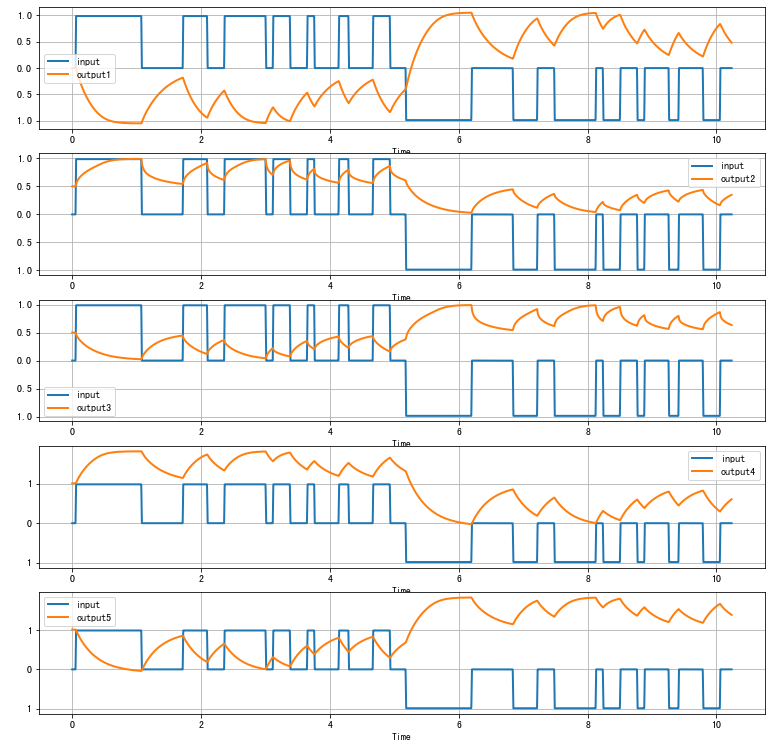

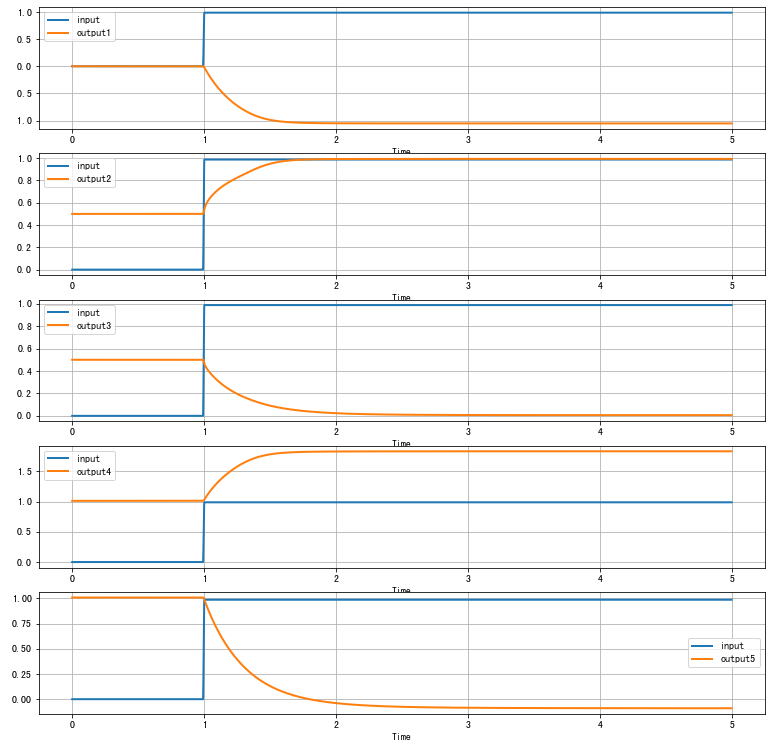

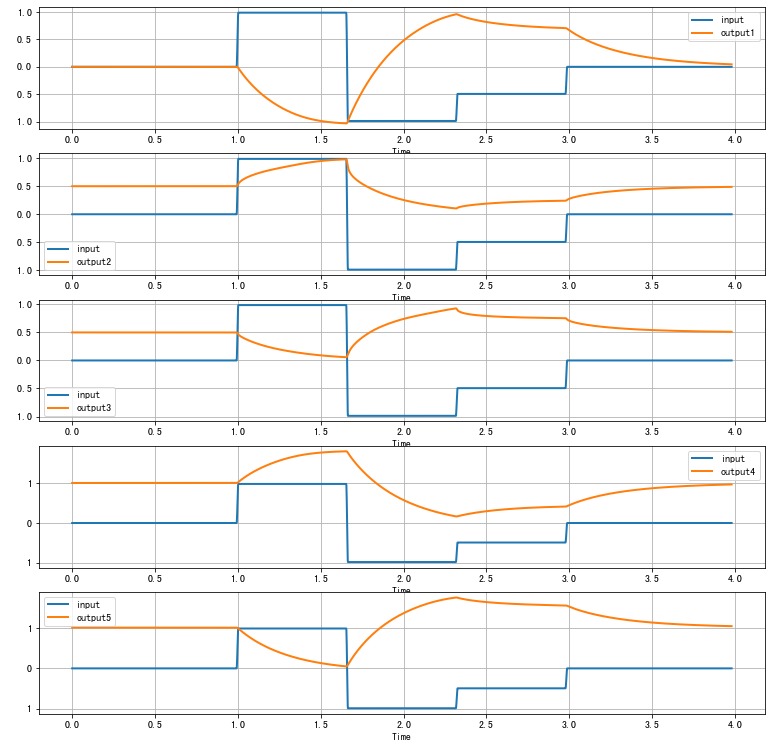

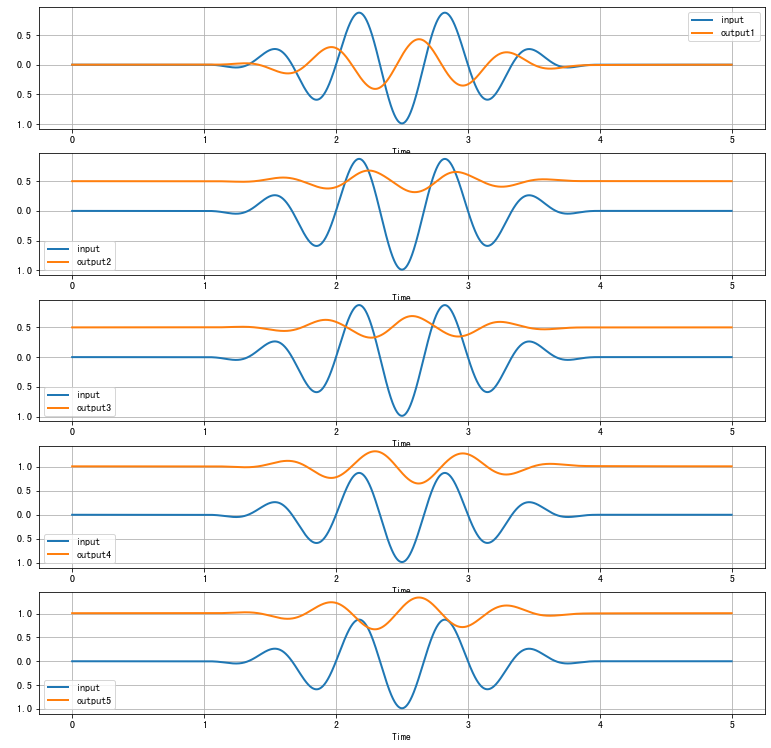

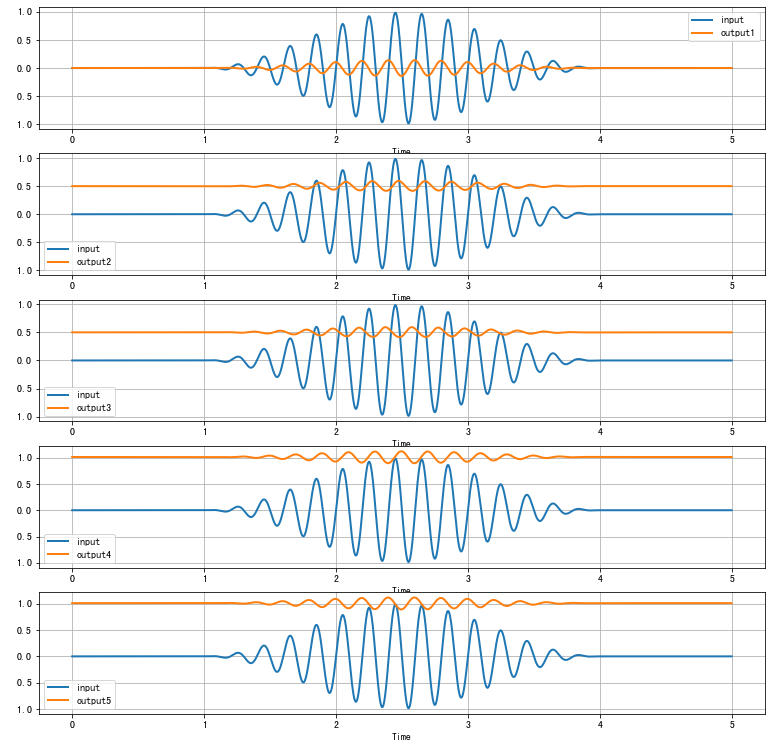

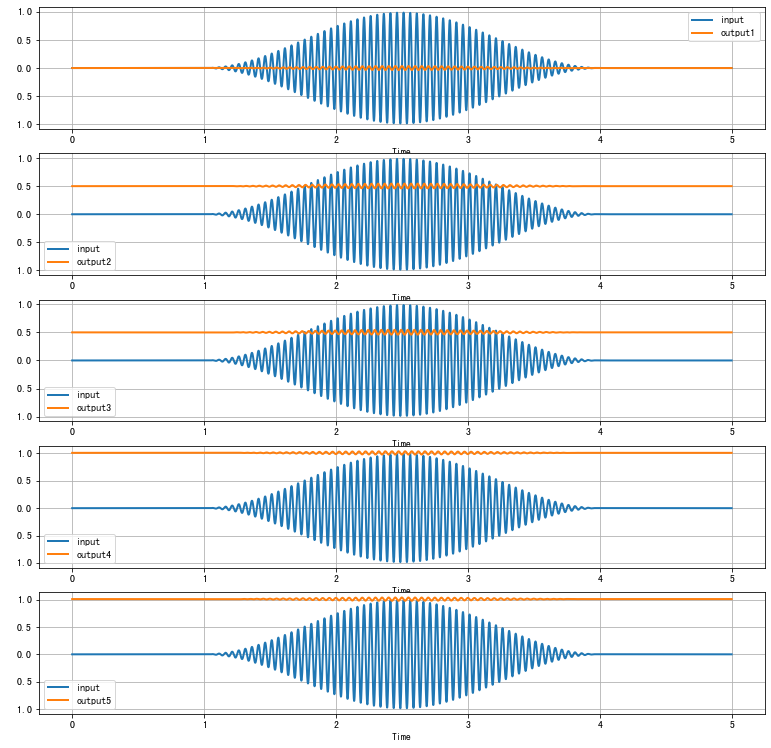

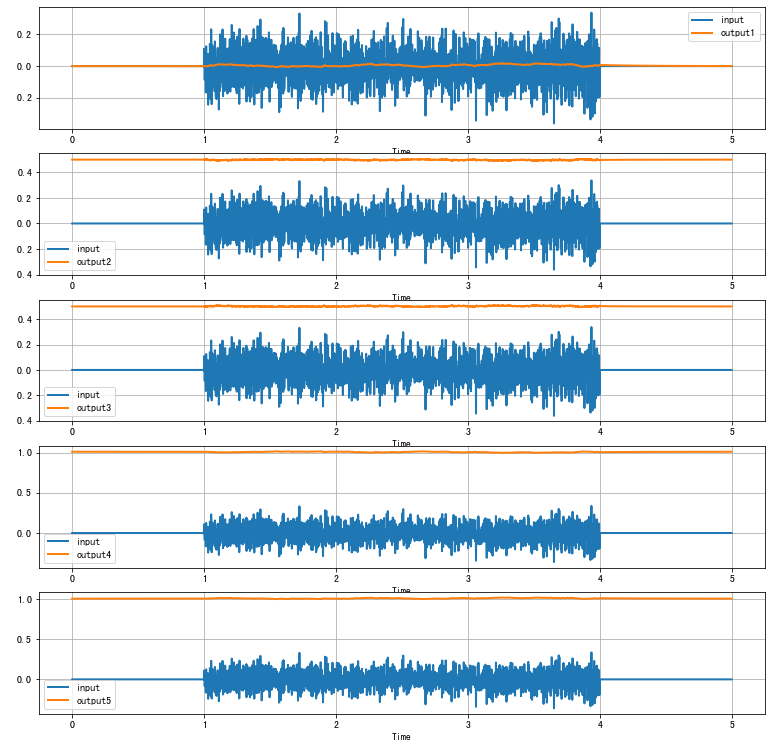

In [25]:
# observer les donnees
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(13,13))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')        

Dans chaque fichier input.csv, la relation entre l'entrée et la sortie n'est pas très similaire, mais nous ne savons pas très bien à quoi cela ressemble.

en fait, pour qql input - output, il y a des season, mais pour certaines comme input1.csv 
c'est surement pas de season, donc c'est trop bizzare pour trouver un grande modele pour tus les donnees

Je doute fort que ces données soient réellement produites par une meme machine ou processor


Étant donné que la taille des données varie de 0 à 1, nous n'avons pas besoin de créer un minmaxscaler pour les données elles-mêmes

Découvrez s'il existe des relations linéaires entre chaque sortie. Si tel est le cas, nous n'avons pas besoin d'un modèle à sorties multiples, nous devons simplement effectuer une conversion entre les résultats.

In [33]:
# Observer le heatmap de FR
corr = d["input0"].corr()
corr




,Time,input,output1,output2,output3,output4,output5
Time,1.000000,-0.647408,0.807472,-0.783934,0.776212,-0.794675,0.809227
input,-0.647408,1.000000,-0.797649,0.858277,-0.857545,0.795705,-0.796017
output1,0.807472,-0.797649,1.000000,-0.988624,0.988826,-0.998622,0.998318
output2,-0.783934,0.858277,-0.988624,1.000000,-0.994070,0.988434,-0.988795
output3,0.776212,-0.857545,0.988826,-0.994070,1.000000,-0.988593,0.989067
output4,-0.794675,0.795705,-0.998622,0.988434,-0.988593,1.000000,-0.995313
output5,0.809227,-0.796017,0.998318,-0.988795,0.989067,-0.995313,1.000000


on peux trouver qu'il y a des realtions entre les outputs, donc mon idea est peux-etre rasional(effectuer une conversion entre les résultats.)

C:\Users\Lintao XU\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Lintao XU\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


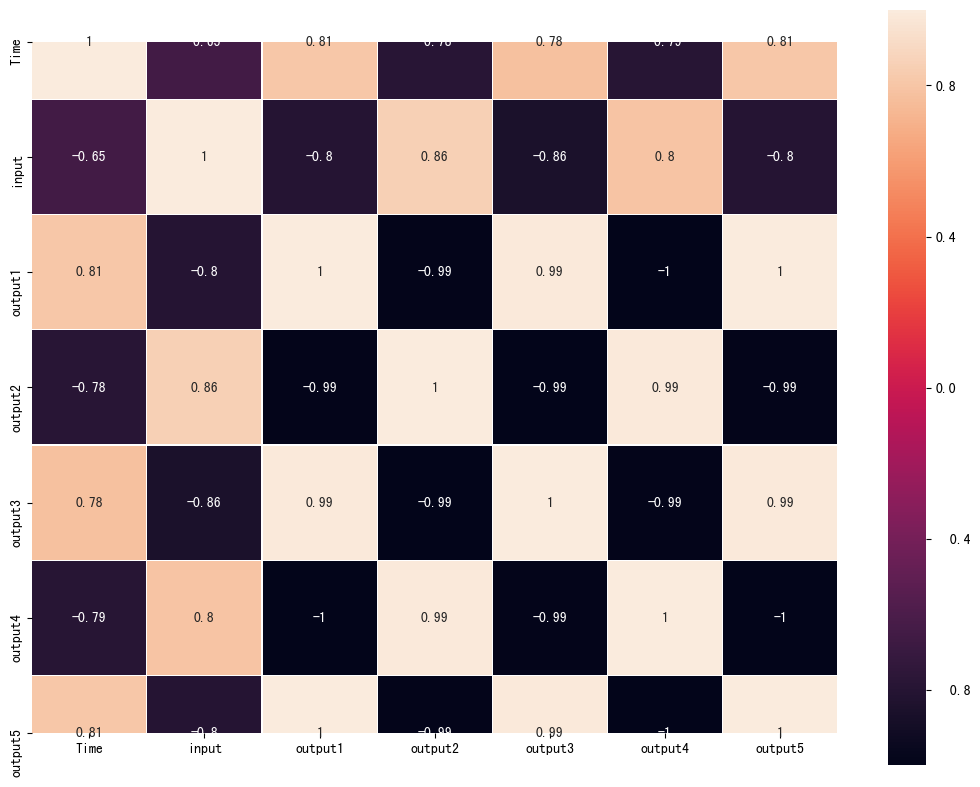

In [32]:
plt.figure(figsize=(13,10), dpi=100)
sns.heatmap(corr, square=True, linewidths=0.1, annot=True)

Du coup miantenant je vais verifier si tous les outputs sont liees dans tous les fichiers csv

In [34]:
corr = d["input1"].corr()
corr

,Time,input,output1,output2,output3,output4,output5
Time,1.000000,0.692674,-0.774800,0.780907,-0.806274,0.775080,-0.816826
input,0.692674,1.000000,-0.937988,0.945309,-0.933599,0.938754,-0.917119
output1,-0.774800,-0.937988,1.000000,-0.999105,0.997075,-0.999996,0.994611
output2,0.780907,0.945309,-0.999105,1.000000,-0.998248,0.999127,-0.995255
output3,-0.806274,-0.933599,0.997075,-0.998248,1.000000,-0.997064,0.998993
output4,0.775080,0.938754,-0.999996,0.999127,-0.997064,1.000000,-0.994516
output5,-0.816826,-0.917119,0.994611,-0.995255,0.998993,-0.994516,1.000000


In [35]:
corr = d["input2"].corr()
corr

,Time,input,output1,output2,output3,output4,output5
Time,1.000000,-0.237498,0.407389,-0.369427,0.364160,-0.408700,0.395960
input,-0.237498,1.000000,-0.710641,0.822862,-0.797274,0.723924,-0.695449
output1,0.407389,-0.710641,1.000000,-0.982390,0.988066,-0.998933,0.998508
output2,-0.369427,0.822862,-0.982390,1.000000,-0.997206,0.984340,-0.979126
output3,0.364160,-0.797274,0.988066,-0.997206,1.000000,-0.990090,0.985003
output4,-0.408700,0.723924,-0.998933,0.984340,-0.990090,1.000000,-0.995252
output5,0.395960,-0.695449,0.998508,-0.979126,0.985003,-0.995252,1.000000


In [36]:
corr = d["input3"].corr()
corr

,Time,input,output1,output2,output3,output4,output5
Time,1.000000,0.000003,-0.002203,-0.001844,-0.004745,0.001472,-0.002922
input,0.000003,1.000000,-0.347519,0.653899,-0.653452,0.361052,-0.361485
output1,-0.002203,-0.347519,1.000000,-0.935073,0.935269,-0.999328,0.999316
output2,-0.001844,0.653899,-0.935073,1.000000,-0.995496,0.939589,-0.939781
output3,-0.004745,-0.653452,0.935269,-0.995496,1.000000,-0.939790,0.939962
output4,0.001472,0.361052,-0.999328,0.939589,-0.939790,1.000000,-0.997758
output5,-0.002922,-0.361485,0.999316,-0.939781,0.939962,-0.997758,1.000000


In [37]:
corr = d["input4"].corr()
corr

,Time,input,output1,output2,output3,output4,output5
Time,1.000000,0.000088,-0.000824,-0.002766,-0.003683,-0.000820,-0.002440
input,0.000088,1.000000,-0.121525,0.653368,-0.652796,0.167748,-0.167874
output1,-0.000824,-0.121525,1.000000,-0.828367,0.828806,-0.997947,0.997939
output2,-0.002766,0.653368,-0.828367,1.000000,-0.992779,0.852731,-0.852829
output3,-0.003683,-0.652796,0.828806,-0.992779,1.000000,-0.853163,0.853215
output4,-0.000820,0.167748,-0.997947,0.852731,-0.853163,1.000000,-0.996183
output5,-0.002440,-0.167874,0.997939,-0.852829,0.853215,-0.996183,1.000000


In [38]:
corr = d["input5"].corr()
corr

,Time,input,output1,output2,output3,output4,output5
Time,1.000000,0.000001,-0.000043,-0.002113,-0.002136,-0.002974,-0.003046
input,0.000001,1.000000,-0.028384,0.673119,-0.672756,0.130424,-0.130397
output1,-0.000043,-0.028384,1.000000,-0.756495,0.756833,-0.993457,0.993464
output2,-0.002113,0.673119,-0.756495,1.000000,-0.994651,0.818206,-0.818229
output3,-0.002136,-0.672756,0.756833,-0.994651,1.000000,-0.818532,0.818492
output4,-0.002974,0.130424,-0.993457,0.818206,-0.818532,1.000000,-0.994842
output5,-0.003046,-0.130397,0.993464,-0.818229,0.818492,-0.994842,1.000000


In [39]:
corr = d["input6"].corr()
corr

,Time,input,output1,output2,output3,output4,output5
Time,1.000000,-0.005615,0.284121,-0.176430,0.175417,-0.283799,0.283529
input,-0.005615,1.000000,-0.065612,0.482612,-0.483998,0.090766,-0.090907
output1,0.284121,-0.065612,1.000000,-0.818312,0.816502,-0.999375,0.999364
output2,-0.176430,0.482612,-0.818312,1.000000,-0.999901,0.837604,-0.837864
output3,0.175417,-0.483998,0.816502,-0.999901,1.000000,-0.835888,0.836148
output4,-0.283799,0.090766,-0.999375,0.837604,-0.835888,1.000000,-0.999998
output5,0.283529,-0.090907,0.999364,-0.837864,0.836148,-0.999998,1.000000


tous les outputs sont lies

EDA pour les details de donnees


des modeles


voir les donnes
1. utiliser les packages prophet facebook

2. utliser ARIMA (defaut, seul input, seul output)
mais peux tester les season

methode finale?

1. Feature design:  max min, etc  ---- SGBoost  decision tree etc

2. direct dans les modele LSTM, ENCODER-DECODER  /  train avec feature

3. deux-step model, premier train un modele de input - output, apres obtenir tous les autre  par le output on a

determiner si les modele adaptes dans le fichier unit.py test.py
